# 📈 DEMAND FORECASTING (Proxy-Based)


**We use REVIEW COUNT as a PROXY for demand.**

### Why?
- We don't have actual sales/order data
- Research shows review count is proportional to sales (~1-5% of buyers review)
- Valid for **relative comparisons** and **trend analysis**

### Limitations:
- Cannot predict exact sales numbers
- Review rate varies by product/category
- Reviews are delayed from actual purchase

### What This Model Predicts:
- **Relative demand trends** (up/down/stable)
- **Seasonality patterns** (holiday spikes)
- **Product popularity forecasts**


In [1]:
# =============================================================================
# 1. IMPORTS & SETUP
# =============================================================================

import polars as pl
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Statistical models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

# ML models
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib
import os

print("✅ Libraries loaded!")


✅ Libraries loaded!


In [2]:
# =============================================================================
# 2. LOAD DATA
# =============================================================================

SAMPLE_SIZE = 100000

# Load reviews
reviews_path = "../dataset/Home_and_Kitchen.jsonl"
reviews = pl.read_ndjson(reviews_path, n_rows=SAMPLE_SIZE)
print(f"✅ Loaded {len(reviews):,} reviews")

# Check columns
print(f"\nColumns: {reviews.columns}")
print(f"\nSample:")
reviews.head(3)


✅ Loaded 100,000 reviews

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Sample:


rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
f64,str,str,list[struct[4]],str,str,str,i64,i64,bool
1.0,"""Received Used & scratched item…","""Livid. Once again received an…",[],"""B007WQ9YNO""","""B09XWYG6X1""","""AFKZENTNBQ7A7V7UXW5JJI6UGRYQ""",1677373409298,1,true
5.0,"""Excellent for moving & storage…","""I purchased these for multiple…",[],"""B09H2VJW6K""","""B0BXDLF8TW""","""AFKZENTNBQ7A7V7UXW5JJI6UGRYQ""",1672043410846,0,true
2.0,"""Lid very loose- needs a gasket…","""[[VIDEOID:c87e962bc893a948856b…","[{""https://m.media-amazon.com/images/I/616kZbRGDpL._SL256_.jpg"",""https://m.media-amazon.com/images/I/616kZbRGDpL._SL800_.jpg"",""https://m.media-amazon.com/images/I/616kZbRGDpL._SL1600_.jpg"",""IMAGE""}, {""https://m.media-amazon.com/images/I/61FTfrIYkxL._SL256_.jpg"",""https://m.media-amazon.com/images/I/61FTfrIYkxL._SL800_.jpg"",""https://m.media-amazon.com/images/I/61FTfrIYkxL._SL1600_.jpg"",""IMAGE""}, … {""https://m.media-amazon.com/images/I/71y2uLtNCSL._SL256_.jpg"",""https://m.media-amazon.com/images/I/71y2uLtNCSL._SL800_.jpg"",""https://m.media-amazon.com/images/I/71y2uLtNCSL._SL1600_.jpg"",""IMAGE""}]","""B07RL297VR""","""B09G2PW8ZG""","""AFKZENTNBQ7A7V7UXW5JJI6UGRYQ""",1653447296788,0,true


In [3]:
# =============================================================================
# 3. DATA EXPLORATION - TIME RANGE
# =============================================================================

# Convert timestamp to datetime
reviews = reviews.with_columns([
    pl.from_epoch(pl.col('timestamp'), time_unit='ms').alias('date')
])

# Extract date components
reviews = reviews.with_columns([
    pl.col('date').dt.year().alias('year'),
    pl.col('date').dt.month().alias('month'),
    pl.col('date').dt.week().alias('week'),
    pl.col('date').dt.date().alias('review_date')
])

print("📅 TIME RANGE ANALYSIS")
print("=" * 40)
print(f"Earliest review: {reviews['date'].min()}")
print(f"Latest review:   {reviews['date'].max()}")

# Reviews per year
yearly = reviews.group_by('year').len().sort('year')
print(f"\n📊 Reviews by Year:")
print(yearly)


📅 TIME RANGE ANALYSIS
Earliest review: 2000-08-06 19:00:47
Latest review:   2023-03-17 04:42:06.497000

📊 Reviews by Year:
shape: (24, 2)
┌──────┬───────┐
│ year ┆ len   │
│ ---  ┆ ---   │
│ i32  ┆ u32   │
╞══════╪═══════╡
│ 2000 ┆ 20    │
│ 2001 ┆ 11    │
│ 2002 ┆ 5     │
│ 2003 ┆ 8     │
│ 2004 ┆ 18    │
│ …    ┆ …     │
│ 2019 ┆ 11669 │
│ 2020 ┆ 17855 │
│ 2021 ┆ 19682 │
│ 2022 ┆ 16830 │
│ 2023 ┆ 3100  │
└──────┴───────┘


In [4]:
# =============================================================================
# 4. AGGREGATE TO WEEKLY DEMAND (PROXY)
# =============================================================================

# Create year-week identifier
reviews = reviews.with_columns([
    (pl.col('year').cast(pl.Utf8) + "-W" + pl.col('week').cast(pl.Utf8).str.zfill(2)).alias('year_week')
])

# Aggregate: count reviews per product per week = DEMAND PROXY
weekly_demand = (
    reviews
    .group_by(['parent_asin', 'year_week', 'year', 'week'])
    .agg([
        pl.len().alias('demand'),  # Review count as demand proxy
        pl.col('rating').mean().alias('avg_rating')
    ])
    .sort(['parent_asin', 'year_week'])
)

print(f"✅ Aggregated to {len(weekly_demand):,} product-week combinations")
print(f"\nSample:")
weekly_demand.head(10)


✅ Aggregated to 98,556 product-week combinations

Sample:


parent_asin,year_week,year,week,demand,avg_rating
str,str,i32,i8,u32,f64
"""0307586901""","""2011-W40""",2011,40,1,3.0
"""0615638309""","""2020-W05""",2020,5,1,5.0
"""0976990792""","""2014-W01""",2014,1,1,4.0
"""1574867962""","""2016-W07""",2016,7,1,4.0
"""1605161810""","""2014-W01""",2014,1,1,5.0
"""1619928736""","""2019-W35""",2019,35,1,5.0
"""1635440246""","""2020-W34""",2020,34,1,4.0
"""1635444985""","""2020-W35""",2020,35,1,5.0
"""1635448131""","""2022-W31""",2022,31,1,5.0


In [5]:
# =============================================================================
# 5. SELECT TOP PRODUCTS (Need enough data for forecasting)
# =============================================================================

# Count weeks per product
product_weeks = (
    weekly_demand
    .group_by('parent_asin')
    .agg([
        pl.len().alias('num_weeks'),
        pl.col('demand').sum().alias('total_demand')
    ])
    .sort('total_demand', descending=True)
)

print("📊 Products by data availability:")
print(f"Products with 10+ weeks: {len(product_weeks.filter(pl.col('num_weeks') >= 10))}")
print(f"Products with 20+ weeks: {len(product_weeks.filter(pl.col('num_weeks') >= 20))}")
print(f"Products with 50+ weeks: {len(product_weeks.filter(pl.col('num_weeks') >= 50))}")

# Select products with enough data (at least 10 weeks)
MIN_WEEKS = 10
top_products = product_weeks.filter(pl.col('num_weeks') >= MIN_WEEKS)['parent_asin'].to_list()

print(f"\n✅ Selected {len(top_products)} products with {MIN_WEEKS}+ weeks of data")
print(f"\nTop 5 products by total demand:")
product_weeks.head(5)


📊 Products by data availability:
Products with 10+ weeks: 239
Products with 20+ weeks: 37
Products with 50+ weeks: 4

✅ Selected 239 products with 10+ weeks of data

Top 5 products by total demand:


parent_asin,num_weeks,total_demand
str,u32,u32
"""B07D1C573W""",157,210
"""B00U8QEXBS""",60,67
"""B095CQTNS3""",63,67
"""B0B53DWRVW""",63,64
"""B08WYH9T9Y""",44,50


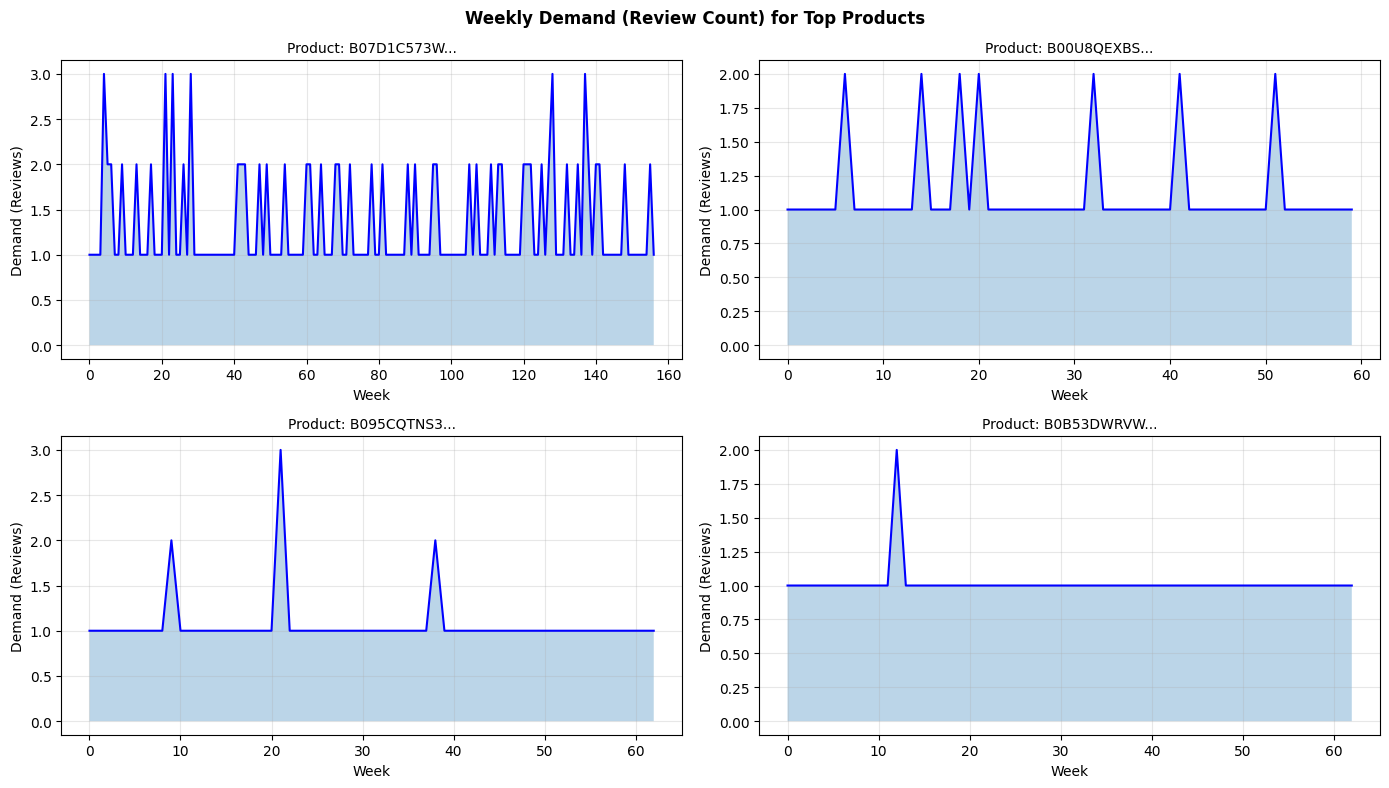

📈 Above: Weekly demand patterns for top 4 products
   Note: Demand = review count (proxy for actual sales)


In [6]:
# =============================================================================
# 6. VISUALIZE DEMAND FOR TOP PRODUCTS
# =============================================================================

# Get top 4 products for visualization
viz_products = product_weeks.head(4)['parent_asin'].to_list()

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, asin in enumerate(viz_products):
    product_data = weekly_demand.filter(pl.col('parent_asin') == asin).sort('year_week')
    
    weeks = product_data['year_week'].to_list()
    demand = product_data['demand'].to_list()
    
    axes[i].plot(range(len(demand)), demand, 'b-', linewidth=1.5)
    axes[i].fill_between(range(len(demand)), demand, alpha=0.3)
    axes[i].set_title(f'Product: {asin[:12]}...', fontsize=10)
    axes[i].set_xlabel('Week')
    axes[i].set_ylabel('Demand (Reviews)')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Weekly Demand (Review Count) for Top Products', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("📈 Above: Weekly demand patterns for top 4 products")
print("   Note: Demand = review count (proxy for actual sales)")


## 📐 MATH: Time Series Forecasting

### Moving Average (Baseline)
Simple average of last n periods:
$$\hat{y}_{t+1} = \frac{1}{n} \sum_{i=0}^{n-1} y_{t-i}$$

### ARIMA (p, d, q)
- **AR(p)**: Autoregressive - use past values
- **I(d)**: Integrated - differencing for stationarity
- **MA(q)**: Moving Average - use past errors

$$y_t = c + \phi_1 y_{t-1} + ... + \phi_p y_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

### Exponential Smoothing (Holt-Winters)
Weighted average giving more weight to recent observations:
$$\hat{y}_{t+1} = \alpha y_t + (1-\alpha) \hat{y}_t$$

### Gradient Boosting
Ensemble of decision trees trained sequentially to minimize prediction error.


📦 Demo product: B07D1C573W
Time series length: 157 weeks
Mean demand: 1.34
Std demand: 0.55


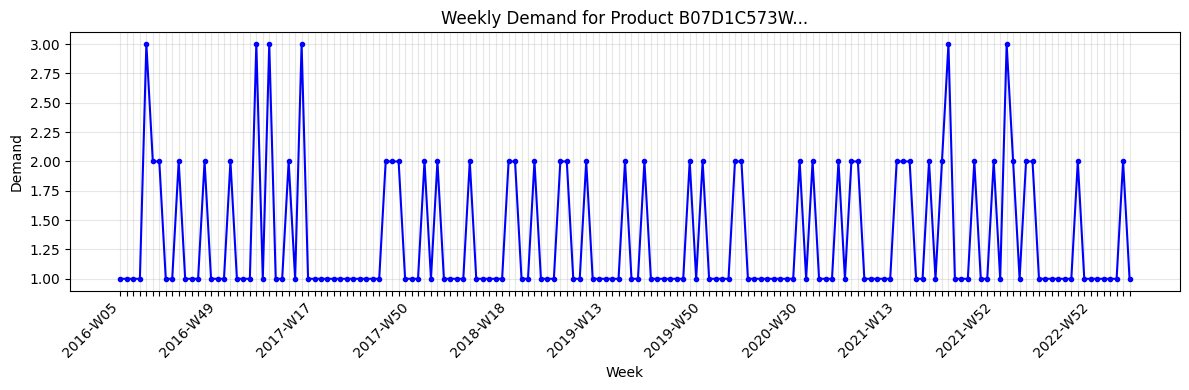

In [7]:
# =============================================================================
# 7. PREPARE TIME SERIES FOR ONE PRODUCT (Demo)
# =============================================================================

# Select the product with most data
demo_product = top_products[0] if top_products else viz_products[0]
print(f"📦 Demo product: {demo_product}")

# Get time series
ts_data = (
    weekly_demand
    .filter(pl.col('parent_asin') == demo_product)
    .sort('year_week')
)

# Convert to pandas for statsmodels
ts_pd = ts_data.select(['year_week', 'demand']).to_pandas()
ts_pd.set_index('year_week', inplace=True)

print(f"Time series length: {len(ts_pd)} weeks")
print(f"Mean demand: {ts_pd['demand'].mean():.2f}")
print(f"Std demand: {ts_pd['demand'].std():.2f}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(ts_pd.index, ts_pd['demand'], 'b-o', markersize=3)
plt.title(f'Weekly Demand for Product {demo_product[:15]}...')
plt.xlabel('Week')
plt.ylabel('Demand')
plt.xticks(rotation=45, ha='right')
# Show only every nth label
n = max(1, len(ts_pd) // 10)
for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
    if i % n != 0:
        label.set_visible(False)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


📊 Train/Test Split (Time-based):
   Training: 125 weeks (2016-W05 to 2021-W23)
   Testing:  32 weeks (2021-W24 to 2023-W10)


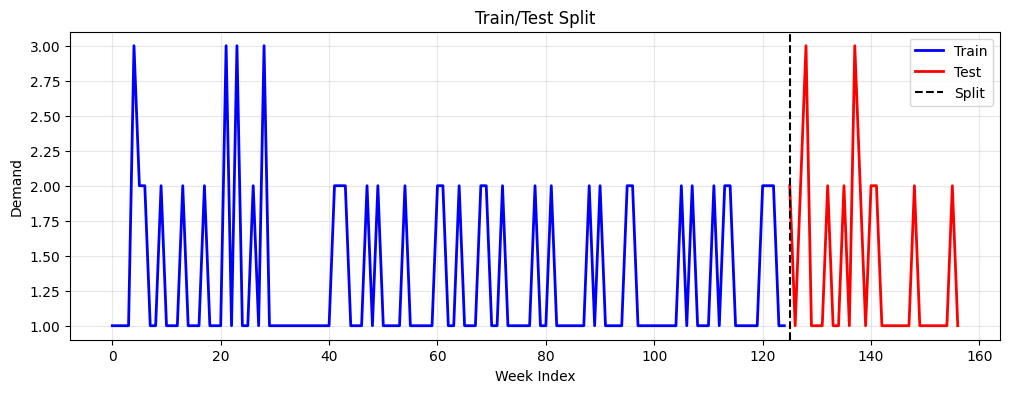

In [8]:
# =============================================================================
# 8. TRAIN/TEST SPLIT (Time-based)
# =============================================================================

# Use last 20% for testing
train_size = int(len(ts_pd) * 0.8)
train = ts_pd.iloc[:train_size]
test = ts_pd.iloc[train_size:]

print(f"📊 Train/Test Split (Time-based):")
print(f"   Training: {len(train)} weeks ({train.index[0]} to {train.index[-1]})")
print(f"   Testing:  {len(test)} weeks ({test.index[0]} to {test.index[-1]})")

# Visualize split
plt.figure(figsize=(12, 4))
plt.plot(range(len(train)), train['demand'], 'b-', label='Train', linewidth=2)
plt.plot(range(len(train), len(ts_pd)), test['demand'], 'r-', label='Test', linewidth=2)
plt.axvline(x=len(train), color='k', linestyle='--', label='Split')
plt.title('Train/Test Split')
plt.xlabel('Week Index')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
# =============================================================================
# 9. MODEL 1: MOVING AVERAGE (Baseline)
# =============================================================================

def moving_average_forecast(train_data, test_len, window=4):
    """Simple moving average forecast."""
    predictions = []
    history = list(train_data['demand'].values)
    
    for _ in range(test_len):
        # Predict: average of last 'window' values
        pred = np.mean(history[-window:])
        predictions.append(pred)
        # Add prediction to history for next forecast
        history.append(pred)
    
    return np.array(predictions)

# Forecast
ma_predictions = moving_average_forecast(train, len(test), window=4)

# Evaluate
ma_mae = mean_absolute_error(test['demand'], ma_predictions)
ma_rmse = np.sqrt(mean_squared_error(test['demand'], ma_predictions))

print("📊 MODEL 1: Moving Average (4-week window)")
print(f"   MAE:  {ma_mae:.2f}")
print(f"   RMSE: {ma_rmse:.2f}")


📊 MODEL 1: Moving Average (4-week window)
   MAE:  0.50
   RMSE: 0.62


In [10]:
# =============================================================================
# 10. MODEL 2: ARIMA
# =============================================================================

# Check stationarity
adf_result = adfuller(train['demand'].values)
print(f"📈 Stationarity Test (ADF):")
print(f"   ADF Statistic: {adf_result[0]:.4f}")
print(f"   p-value: {adf_result[1]:.4f}")
print(f"   Stationary: {'Yes' if adf_result[1] < 0.05 else 'No (need differencing)'}")

# Fit ARIMA
try:
    # Try ARIMA(1,1,1) - common starting point
    arima_model = ARIMA(train['demand'].values, order=(1, 1, 1))
    arima_fit = arima_model.fit()
    
    # Forecast
    arima_predictions = arima_fit.forecast(steps=len(test))
    
    # Evaluate
    arima_mae = mean_absolute_error(test['demand'], arima_predictions)
    arima_rmse = np.sqrt(mean_squared_error(test['demand'], arima_predictions))
    
    print(f"\n📊 MODEL 2: ARIMA(1,1,1)")
    print(f"   MAE:  {arima_mae:.2f}")
    print(f"   RMSE: {arima_rmse:.2f}")
except Exception as e:
    print(f"⚠️ ARIMA failed: {e}")
    arima_predictions = ma_predictions  # Fallback
    arima_mae = ma_mae
    arima_rmse = ma_rmse


📈 Stationarity Test (ADF):
   ADF Statistic: -11.6615
   p-value: 0.0000
   Stationary: Yes

📊 MODEL 2: ARIMA(1,1,1)
   MAE:  0.41
   RMSE: 0.73


In [11]:
# =============================================================================
# 11. MODEL 3: EXPONENTIAL SMOOTHING
# =============================================================================

try:
    # Simple Exponential Smoothing (no trend/seasonality)
    es_model = ExponentialSmoothing(
        train['demand'].values,
        trend=None,
        seasonal=None
    )
    es_fit = es_model.fit()
    
    # Forecast
    es_predictions = es_fit.forecast(steps=len(test))
    
    # Evaluate
    es_mae = mean_absolute_error(test['demand'], es_predictions)
    es_rmse = np.sqrt(mean_squared_error(test['demand'], es_predictions))
    
    print(f"📊 MODEL 3: Exponential Smoothing")
    print(f"   MAE:  {es_mae:.2f}")
    print(f"   RMSE: {es_rmse:.2f}")
except Exception as e:
    print(f"⚠️ Exponential Smoothing failed: {e}")
    es_predictions = ma_predictions
    es_mae = ma_mae
    es_rmse = ma_rmse


📊 MODEL 3: Exponential Smoothing
   MAE:  0.51
   RMSE: 0.61


In [12]:
# =============================================================================
# 12. MODEL 4: GRADIENT BOOSTING (ML Approach)
# =============================================================================

def create_features(data, lags=[1, 2, 4]):
    """Create lag features for ML model."""
    df = data.copy()
    
    for lag in lags:
        df[f'lag_{lag}'] = df['demand'].shift(lag)
    
    # Rolling features
    df['rolling_mean_4'] = df['demand'].rolling(window=4).mean()
    df['rolling_std_4'] = df['demand'].rolling(window=4).std()
    
    # Drop NaN rows
    df = df.dropna()
    
    return df

# Create features for full dataset
ts_features = create_features(ts_pd)

# Re-split with features
feature_cols = ['lag_1', 'lag_2', 'lag_4', 'rolling_mean_4', 'rolling_std_4']
train_size_feat = int(len(ts_features) * 0.8)

X_train = ts_features[feature_cols].iloc[:train_size_feat]
y_train = ts_features['demand'].iloc[:train_size_feat]
X_test = ts_features[feature_cols].iloc[train_size_feat:]
y_test = ts_features['demand'].iloc[train_size_feat:]

print(f"Feature dataset: {len(ts_features)} samples")
print(f"Train: {len(X_train)}, Test: {len(X_test)}")

# Train Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)

# Predict
gb_predictions = gb_model.predict(X_test)

# Evaluate
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_predictions))

print(f"\n📊 MODEL 4: Gradient Boosting")
print(f"   MAE:  {gb_mae:.2f}")
print(f"   RMSE: {gb_rmse:.2f}")

# Feature importance
print(f"\n📊 Feature Importance:")
for feat, imp in sorted(zip(feature_cols, gb_model.feature_importances_), key=lambda x: -x[1]):
    print(f"   {feat}: {imp:.3f}")


Feature dataset: 153 samples
Train: 122, Test: 31

📊 MODEL 4: Gradient Boosting
   MAE:  0.37
   RMSE: 0.61

📊 Feature Importance:
   rolling_mean_4: 0.431
   lag_1: 0.190
   lag_2: 0.181
   rolling_std_4: 0.118
   lag_4: 0.080


In [13]:
# =============================================================================
# 13. MODEL COMPARISON
# =============================================================================

results = {
    'Moving Average': {'MAE': ma_mae, 'RMSE': ma_rmse},
    'ARIMA(1,1,1)': {'MAE': arima_mae, 'RMSE': arima_rmse},
    'Exp. Smoothing': {'MAE': es_mae, 'RMSE': es_rmse},
    'Gradient Boost': {'MAE': gb_mae, 'RMSE': gb_rmse}
}

print("=" * 50)
print("📊 MODEL COMPARISON")
print("=" * 50)
print(f"{'Model':<20} {'MAE':>10} {'RMSE':>10}")
print("-" * 50)

best_model = None
best_mae = float('inf')

for model, metrics in results.items():
    print(f"{model:<20} {metrics['MAE']:>10.2f} {metrics['RMSE']:>10.2f}")
    if metrics['MAE'] < best_mae:
        best_mae = metrics['MAE']
        best_model = model

print("-" * 50)
print(f"🏆 Best Model: {best_model} (MAE: {best_mae:.2f})")


📊 MODEL COMPARISON
Model                       MAE       RMSE
--------------------------------------------------
Moving Average             0.50       0.62
ARIMA(1,1,1)               0.41       0.73
Exp. Smoothing             0.51       0.61
Gradient Boost             0.37       0.61
--------------------------------------------------
🏆 Best Model: Gradient Boost (MAE: 0.37)


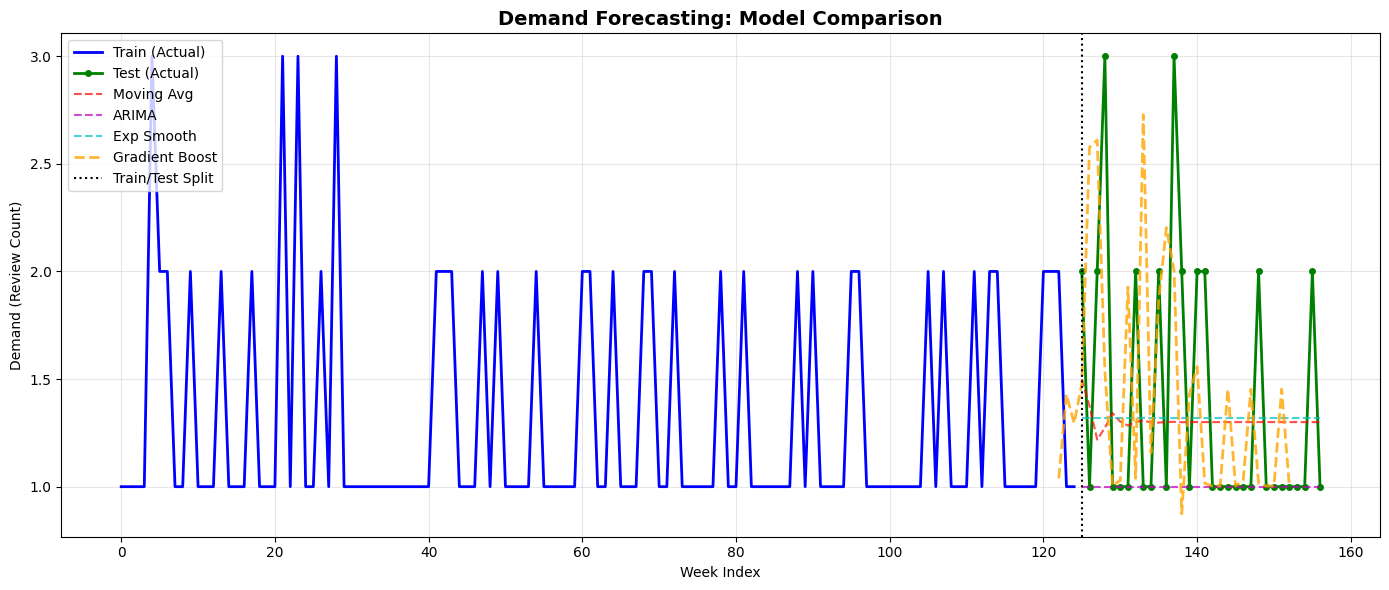

📈 Green = Actual test values, Dashed = Model predictions


In [14]:
# =============================================================================
# 14. VISUALIZE PREDICTIONS
# =============================================================================

plt.figure(figsize=(14, 6))

# Plot actual
plt.plot(range(len(train)), train['demand'], 'b-', label='Train (Actual)', linewidth=2)
test_range = range(len(train), len(train) + len(test))
plt.plot(test_range, test['demand'], 'g-', label='Test (Actual)', linewidth=2, marker='o', markersize=4)

# Plot predictions
plt.plot(test_range, ma_predictions, 'r--', label='Moving Avg', alpha=0.7)
plt.plot(test_range, arima_predictions, 'm--', label='ARIMA', alpha=0.7)
plt.plot(test_range, es_predictions, 'c--', label='Exp Smooth', alpha=0.7)

# GB predictions (different test set due to lag features)
if len(X_test) > 0:
    gb_start = len(ts_features) - len(X_test)
    gb_test_range = range(gb_start, gb_start + len(gb_predictions))
    plt.plot(gb_test_range, gb_predictions, 'orange', linestyle='--', label='Gradient Boost', alpha=0.8, linewidth=2)

plt.axvline(x=len(train), color='k', linestyle=':', label='Train/Test Split')
plt.title('Demand Forecasting: Model Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Week Index')
plt.ylabel('Demand (Review Count)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("📈 Green = Actual test values, Dashed = Model predictions")


In [15]:
# =============================================================================
# 15. SAVE MODELS
# =============================================================================

models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save Gradient Boosting model (best ML model)
joblib.dump(gb_model, f"{models_dir}/demand_forecast_gb.joblib")
print(f"✅ Saved: demand_forecast_gb.joblib")

# Save model info
import json
model_info = {
    "model_type": "GradientBoostingRegressor",
    "features": feature_cols,
    "demo_product": demo_product,
    "metrics": {
        "MAE": float(gb_mae),
        "RMSE": float(gb_rmse)
    },
    "assumption": "Review count used as proxy for demand",
    "limitations": [
        "Cannot predict exact sales numbers",
        "Only valid for relative trend analysis",
        "Review rate varies by product"
    ]
}

with open(f"{models_dir}/demand_forecast_info.json", 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✅ Saved: demand_forecast_info.json")

print("\n" + "=" * 50)
print("📦 DEMAND FORECASTING COMPLETE!")
print("=" * 50)


✅ Saved: demand_forecast_gb.joblib
✅ Saved: demand_forecast_info.json

📦 DEMAND FORECASTING COMPLETE!


## 📋 Summary

### What We Built:
1. **Data Pipeline**: Reviews → Weekly demand aggregation per product
2. **4 Models**: Moving Average, ARIMA, Exponential Smoothing, Gradient Boosting
3. **Evaluation**: MAE and RMSE on held-out test set (time-based split)

### Key Assumption:
**Review count ∝ Demand** (proportional relationship)
- ~1-5% of buyers leave reviews
- More reviews = More sales (relative comparison)

### Business Use Cases:
- 📈 **Trend Detection**: Is product demand increasing/decreasing?
- 🎄 **Seasonality**: Identify holiday spikes (Q4)
- 📊 **Relative Comparison**: Compare demand across products
- ⚠️ **Anomaly Detection**: Sudden demand changes (viral product? quality issue?)

### Limitations:
- ❌ Cannot predict exact sales numbers
- ❌ Review rate varies by product/category
- ❌ Not suitable for precise inventory planning (need real sales data)
- ✅ Valid for trend analysis and relative comparisons
